In [25]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report, mean_squared_error, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, RepeatedKFold

from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.facecolor'] = 'white'

# Function definitions

In [5]:
def import_data(filepath):
    f = h5py.File(filepath, 'r')
    V = f['voltage'][...]
    Ca = f['calcium'][...]
    t = f['time'][...]
    labels = f['labels'][...]
    return V, Ca, t, labels


def normalize_traces(traces_a, traces_b=None):
    if traces_b == None:
        traces_a_norm = []
        for trace in traces_a:
            trace_norm = (trace - trace.min()) / (trace.max() - trace.min())
            traces_a_norm.append(trace_norm)
        traces_a_norm = np.array(traces_a_norm)
        return traces_a_norm
    else:  # if pass two sets of traces, normalize traces_b relative to traces_a
        traces_a_norm, traces_b_norm = [], []
        for trace_a, trace_b in zip(traces_a, traces_b):
            traces_a_norm.append(
                (trace_a - trace_a.min()) / (trace_a.max() - trace_a.min()))
            traces_b_norm.append(
                (trace_b - trace_a.min()) / (trace_a.max() - trace_a.min()))
        traces_a_norm = np.array(traces_a_norm)
        traces_b_norm = np.array(traces_b_norm)
        return traces_a_norm, traces_b_norm


def add_noise(X, percentage=5.0):
    std = np.nanmean(X, axis=0).std()
    noise = np.random.normal(0, std, X.shape) * percentage / 100
    X_noise = X + noise
    return X_noise

# Import data

In [33]:
data_path = "/Volumes/GoogleDrive/My Drive/Simula/SSCP21/SSCP21_Project9/code/data.h5"
label_order = ['Kr', 'CaL', 'Na', 'NaL', 'to', 'Ks', 'K1']

V, Ca, t, labels = import_data(data_path)
# Separate control and drug cases
V_c = V[:, :, 0]
V_d = V[:, :, 1]
Ca_c = Ca[:, :, 0]
Ca_d = Ca[:, :, 1]

# Plot data

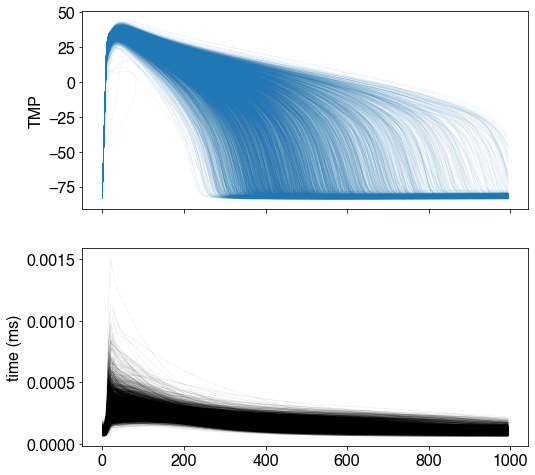

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for Vp, Cap in zip(V_c, Ca_c):
    ax[0].plot(t, Vp, c='tab:blue', lw=0.4, alpha=0.1)
    ax[1].plot(t, Cap, c='k', lw=0.4, alpha=0.1)
    ax[0].set_ylabel("TMP")
    ax[1].set_ylabel("Calcium")
    ax[1].set_ylabel("time (ms)")

# Prep data for classifier

In [34]:
# Add noise and combine V with Ca
pct_noise = 0.0
V_c_norm, V_d_norm = normalize_traces(add_noise(V_c,pct_noise)), normalize_traces(add_noise(V_d,pct_noise))
Ca_c_norm, Ca_d_norm = normalize_traces(add_noise(Ca_c,pct_noise)), normalize_traces(add_noise(Ca_d,pct_noise))
X = np.concatenate((V_d_norm-V_c_norm,Ca_d_norm-Ca_c_norm),axis=1)

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = labels

# Split into training and testing
ratio = 0.3 # test/total
indices = np.arange(X.shape[0])
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = ratio)
# X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_sparse, indices, test_size=ratio, random_state=None)

# Train and test classifier
## Naive Bayes

In [27]:
clf = BinaryRelevance(classifier = GaussianNB())

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i}:",accuracy_score(y_test[:,i],y_hat[:,i]))


training time:  0.14 seconds
Accuracy label 0: 0.7748489840746843
Accuracy label 1: 0.7550796265788029
Accuracy label 2: 0.5189456342668863
Accuracy label 3: 0.5606809445359693
Accuracy label 4: 0.5475013728720484
Accuracy label 5: 0.5458539264140582
Accuracy label 6: 0.5293794618341571


In [28]:
# Use multi-label classifier chain (MLCC)
clf = ClassifierChain( classifier = GaussianNB() )

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))

training time:  0.17 seconds
Accuracy label 0: 0.7748489840746843
Accuracy label 1: 0.7550796265788029
Accuracy label 2: 0.5189456342668863
Accuracy label 3: 0.5634266886326195
Accuracy label 4: 0.5475013728720484
Accuracy label 5: 0.5447556287753982
Accuracy label 6: 0.528281164195497


In [42]:
# Formulate as label power-set
clf = LabelPowerset( classifier = GaussianNB() )

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))
    
# clf.unique_combinations_

training time:  0.07 seconds
Accuracy label 0 (Kr): 0.9006622516556292
Accuracy label 1 (CaL): 0.9194260485651214
Accuracy label 2 (Na): 0.7687637969094923
Accuracy label 3 (NaL): 0.6545253863134658
Accuracy label 4 (to): 0.6837748344370861
Accuracy label 5 (Ks): 0.5413907284768212
Accuracy label 6 (K1): 0.7008830022075055


## SVC

In [63]:
# Start with binary relevance
clf = BinaryRelevance( classifier = SVC(kernel='linear', C=1, gamma='scale', probability=True) )

start = time.time()
clf.fit(X_train, y_train)
print('training time: ',round(time.time()-start,2),'seconds')

y_hat = clf.predict(X_test).toarray().astype(int)
for i in range(7):
    print(f"Accuracy label {i} ({label_order[i]}):",accuracy_score(y_test[:,i],y_hat[:,i]))

training time:  56.6 seconds
Accuracy label 0: 0.9822518025513034
Accuracy label 1: 0.9955629506378258
Accuracy label 2: 0.9922351636161952
Accuracy label 3: 0.6666666666666666
Accuracy label 4: 0.9883527454242929
Accuracy label 5: 0.581808097615086
Accuracy label 6: 0.9622850804215197


## MLP neural net with cross-validation

In [24]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in tqdm(cv.split(X), total=30):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # make a prediction on the test set
        y_hat = model.predict(X_test)
        # round probabilities to class labels
        y_hat = y_hat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, y_hat)
        # store result
        results.append(acc)
    return results

results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))

 10%|█         | 3/30 [00:30<04:35, 10.19s/it]


KeyboardInterrupt: 